# Biweekly Report 1
## Kyle, Carney
### Iris Exploratory Data Analysis

In this biweekly report I perform an Exploratory Data Analysis (EDA) on Fisher's Iris dataset in order to evaluate its use as a training dataset. For my EDA, I ensure that the dataset is balanced, sufficiently varied across target classes, and contains a minimal number of outliers. My EDA suggests that the training dataset can be improved by excluding the sepal measurements. To test this hypothesis I train three models: one with the full dataset, one with the petal data, and one with the sepal data. I found that the model trained with just the petal data eventually outperforms the other two models.

In [154]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
import tqdm
import numpy as np
import random


from torch.autograd import Variable
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

#read csv
df = pd.read_csv("iris-flower-dataset/IRIS.csv")

### Background
The Iris dataset was published in Dr. Ronald Fisher's 1936 paper "The use of multiple measurements in taxonomic problems". The dataset contains the sepal length, sepal width, petal length, and petal width from 50 samples of three Iris species: I. setosa, I. versicolor, and I. virginica. The sepal and petal measurements were performed by Dr.Edgar Anderson, an accomplished american botanist. All samples of I. setosa and I. versicolor were collected from the same colony. Note, this data set is well balanced as each species has an equal number representative samples.

### Mean and standard deviation

I wish to train a model to identify the species of an Iris flower based on its measured morphological traits. Therefore, I find the mean and standard deviation of each trait to identify which morphologies significantly vary by species. Ideally, the mean trait of a particular species would not be within a few standard deviations of any other species.



In [155]:
#Iris-setosa
dfm1 = df.iloc[0:49,0:4].mean(axis = 0)
dfsd1 = df.iloc[0:49,0:4].std(axis = 0)

#Iris-versicolor
dfm2 = df.iloc[50:99,0:4].mean(axis = 0)
dfsd2 = df.iloc[50:99,0:4].std(axis = 0)

#Iris-virginica
dfm3 = df.iloc[100:149,0:4].mean(axis = 0)
dfsd3 = df.iloc[100:149,0:4].std(axis = 0)

result = pd.concat([dfm1, dfsd1, dfm2, dfsd2,dfm3, dfsd3], axis=1)
result.columns = [ 'mean:setosa', 'stdev:setosa', 'mean:versicolor', 'stdev:versicolor', 'mean:virginica' , 'stdev:virginica']

print(result)

              mean:setosa  stdev:setosa  mean:versicolor  stdev:versicolor  \
sepal_length     5.006122      0.356141         5.940816          0.520384   
sepal_width      3.420408      0.384588         2.769388          0.317020   
petal_length     1.465306      0.175061         4.263265          0.474207   
petal_width      0.244898      0.108130         1.326531          0.199766   

              mean:virginica  stdev:virginica  
sepal_length        6.602041         0.634590  
sepal_width         2.973469         0.325817  
petal_length        5.561224         0.553706  
petal_width         2.030612         0.275533  


Note the petal length and width significantly varies by species. However, the sepal length and width of I. versicolor and  I. virginica are similar enough that these traits can not be used to reliably tell these species apart.

### Outliers
Outliers in a training dataset can bias a model and will generally reduce the accuracy of its results. Thus, I will now search the dataset for outliers via the interquartile range.

In [156]:
##Find 1st and 3nd Quartiles
Q1 = df.iloc[:,0:4].quantile(0.25,axis = 0)
Q3 = df.iloc[:,0:4].quantile(0.75,axis = 0)

##Find Interquartile range
IQR = Q3 - Q1

##Define what is considered an outlier
Upper_cutoff = Q3 + 1.5*IQR
Lower_cutoff = Q1 - 1.5*IQR

##Find outlier positions across each of the 4 columns
upper_outliers = (df.iloc[:,0]>= Upper_cutoff[0])
for i in range(3):
    upper_outliers = upper_outliers | (df.iloc[:,i]>= Upper_cutoff[i])

lower_outliers = (df.iloc[:,0]<= Lower_cutoff[0])
for i in range(3):
    lower_outliers = lower_outliers | (df.iloc[:,i]<= Lower_cutoff[i])

##Find combined outlier locations and find values
outliers = lower_outliers | upper_outliers
outliers = df[outliers]

print(outliers)


    sepal_length  sepal_width  petal_length  petal_width          species
15           5.7          4.4           1.5          0.4      Iris-setosa
32           5.2          4.1           1.5          0.1      Iris-setosa
33           5.5          4.2           1.4          0.2      Iris-setosa
60           5.0          2.0           3.5          1.0  Iris-versicolor


This analysis suggests the dataset contains four outliers which means 2.6% of the dataset is composed of outliers. Furthermore, all outliers correspond to the sepal width.

### EDA Results
This EDA suggests the complete dataset would be an adequate training dataset as half of its traits can be reliably used to identify the three species and the set contains only a small amount of outliers. However, I found that the sepal length and width can not reliably be used to identify I. versicolor and I. virginica. Furthermore, all outliers correspond to the sepal width trait. Therefore, including the sepal data offers no real advantage while simultaneously introducing outliers to the dataset. This suggests that the training data can be improved by excluding the sepal length and width and only using the petal measurements.


## Model training
I will now use pytorch to train a model to identify Iris species based on the complete dataset, the petal measurements, and the sepal measurements. Based on my EDA I expect the trimmed data to provide most accurate results. To accomplish this I modified the code found on [https://janakiev.com/blog/pytorch-iris/](https://janakiev.com/blog/pytorch-iris/).

In [157]:
## Data Preparation

plt.style.use('ggplot')

iris = load_iris()
X = iris['data']
y = iris['target']

names = iris['target_names']
feature_names = iris['feature_names']

# Scale data to have mean 0 and variance 1
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#remove first 2 columns
X_trimmed = np.delete(X_scaled, [0,1], 1)

#remove last 2 columns
X_trimmed2 = np.delete(X_scaled, [2,3], 1)


rand_seed = random.randint(0 , 99)

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=rand_seed)

# Split the data set into training and testing
X_trimmed_train, X_trimmed_test, y_trimmed_train, y_trimmed_test = train_test_split(
    X_trimmed, y, test_size=0.2, random_state=rand_seed)

# Split the data set into training and testing
X_trimmed2_train, X_trimmed2_test, y_trimmed2_train, y_trimmed2_test = train_test_split(
    X_trimmed2, y, test_size=0.2, random_state=rand_seed)

print(np.size(X_train,0))
print(np.size(X_test,0))

120
30


In [158]:
### Configure Neural Network Models
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 50)
        self.layer2 = nn.Linear(50, 50)
        self.layer3 = nn.Linear(50, 3)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x

In [159]:
model     = Model(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn   = nn.CrossEntropyLoss()

model_trimmed     = Model(X_trimmed_train.shape[1])
optimizer_trimmed = torch.optim.Adam(model_trimmed.parameters(), lr=0.001)
loss_fn_trimmed   = nn.CrossEntropyLoss()

model_trimmed2     = Model(X_trimmed2_train.shape[1])
optimizer_trimmed2 = torch.optim.Adam(model_trimmed2.parameters(), lr=0.001)
loss_fn_trimmed2   = nn.CrossEntropyLoss()

In [160]:
### Train the Model
EPOCHS  = 100

X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

X_trimmed_train = Variable(torch.from_numpy(X_trimmed_train)).float()
y_trimmed_train = Variable(torch.from_numpy(y_trimmed_train)).long()
X_trimmed_test  = Variable(torch.from_numpy(X_trimmed_test)).float()
y_trimmed_test  = Variable(torch.from_numpy(y_trimmed_test)).long()

X_trimmed2_train = Variable(torch.from_numpy(X_trimmed2_train)).float()
y_trimmed2_train = Variable(torch.from_numpy(y_trimmed2_train)).long()
X_trimmed2_test  = Variable(torch.from_numpy(X_trimmed2_test)).float()
y_trimmed2_test  = Variable(torch.from_numpy(y_trimmed2_test)).long()

loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

loss_list_trimmed     = np.zeros((EPOCHS,))
accuracy_list_trimmed = np.zeros((EPOCHS,))

loss_list_trimmed2     = np.zeros((EPOCHS,))
accuracy_list_trimmed2 = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()

    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

    y_trimmed_pred = model_trimmed(X_trimmed_train)
    loss_trimmed = loss_fn_trimmed(y_trimmed_pred, y_trimmed_train)
    loss_list_trimmed[epoch] = loss_trimmed.item()

    # Zero gradients
    optimizer_trimmed.zero_grad()
    loss_trimmed.backward()
    optimizer_trimmed.step()

    with torch.no_grad():
        y_trimmed_pred = model_trimmed(X_trimmed_test)
        correct_trimmed = (torch.argmax(y_trimmed_pred, dim=1) == y_trimmed_test).type(torch.FloatTensor)
        accuracy_list_trimmed[epoch] = correct_trimmed.mean()

    y_trimmed2_pred = model_trimmed2(X_trimmed2_train)
    loss_trimmed2 = loss_fn_trimmed2(y_trimmed2_pred, y_trimmed_train)
    loss_list_trimmed2[epoch] = loss_trimmed2.item()

    # Zero gradients
    optimizer_trimmed2.zero_grad()
    loss_trimmed2.backward()
    optimizer_trimmed2.step()

    with torch.no_grad():
        y_trimmed2_pred = model_trimmed2(X_trimmed2_test)
        correct_trimmed2 = (torch.argmax(y_trimmed2_pred, dim=1) == y_trimmed2_test).type(torch.FloatTensor)
        accuracy_list_trimmed2[epoch] = correct_trimmed2.mean()

100%|██████████| 100/100 [00:00<00:00, 385.26it/s]


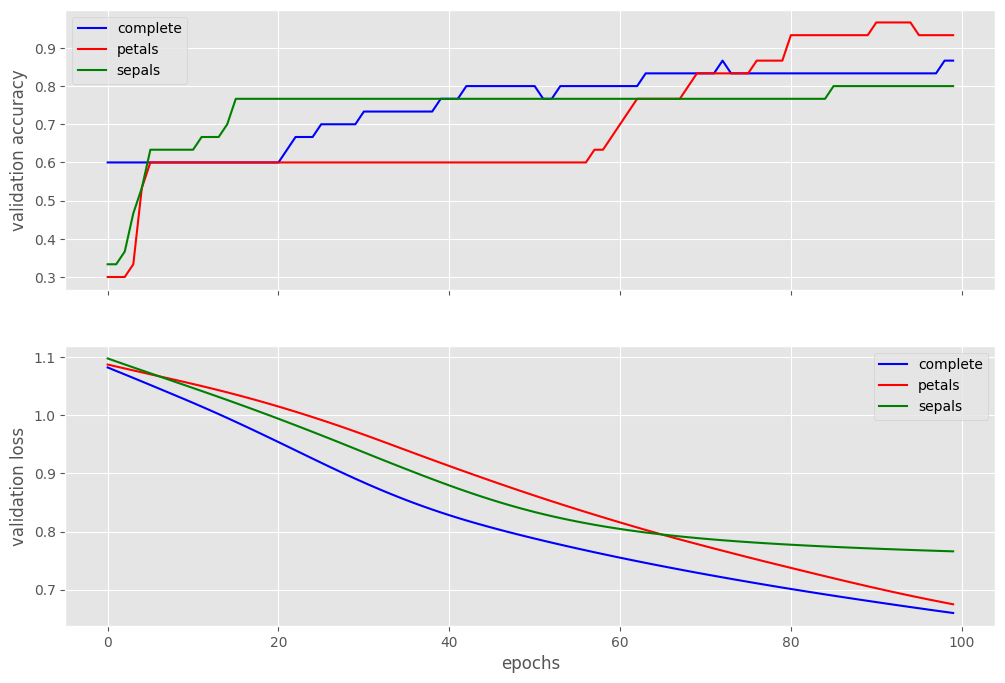

In [161]:
### Plot Accuracy and Loss from Training

fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8), sharex=True)

ax1.set_ylabel("validation accuracy")
ax1.plot(accuracy_list, 'b-', label = "complete")
ax1.plot(accuracy_list_trimmed, 'r', label = "petals")
ax1.plot(accuracy_list_trimmed2, 'g', label = "sepals")
ax1.legend()

ax2.set_ylabel("validation loss")
ax2.plot(loss_list, 'b-', label = "complete")
ax2.plot(loss_list_trimmed, 'r', label = "petals")
ax2.plot(loss_list_trimmed2, 'g', label = "sepals")
ax2.legend()
ax2.set_xlabel("epochs");

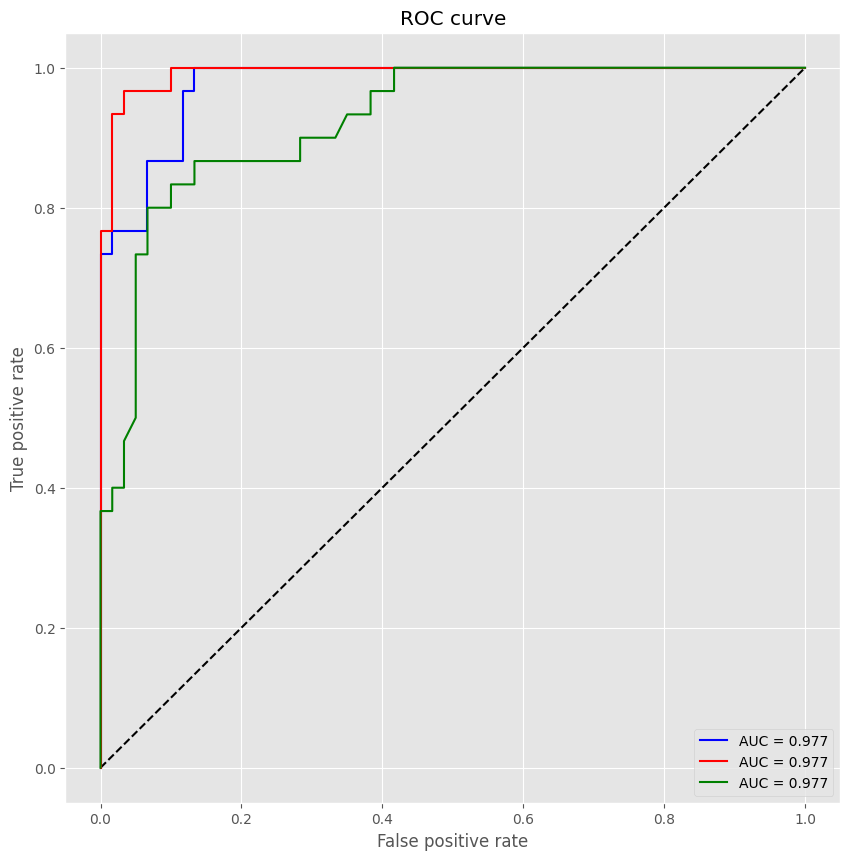

In [162]:
### Show ROC Curve
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = model(X_test).numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())

plt.plot(fpr, tpr, 'b-' , label='AUC = {:.3f}'.format(auc(fpr, tpr)))


# One hot encoding
Y_trimmed_onehot = enc.fit_transform(y_trimmed_test[:, np.newaxis]).toarray()
with torch.no_grad():
    y_trimmed_pred = model_trimmed(X_trimmed_test).numpy()
    fpr_trimmed, tpr_trimmed, threshold_trimmed = roc_curve(Y_trimmed_onehot.ravel(), y_trimmed_pred.ravel())

plt.plot(fpr_trimmed, tpr_trimmed, 'r-' , label='AUC = {:.3f}'.format(auc(fpr, tpr)))

# One hot encoding
Y_trimmed2_onehot = enc.fit_transform(y_trimmed2_test[:, np.newaxis]).toarray()
with torch.no_grad():
    y_trimmed2_pred = model_trimmed2(X_trimmed2_test).numpy()
    fpr_trimmed2, tpr_trimmed2, threshold_trimmed2 = roc_curve(Y_trimmed2_onehot.ravel(), y_trimmed2_pred.ravel())

plt.plot(fpr_trimmed2, tpr_trimmed2, 'g-' , label='AUC = {:.3f}'.format(auc(fpr, tpr)))



plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();



### Conclusion

After training three competing models I found that the best performing model was trained exclusively on petal data. More specifically, the petal trained model has the highest validation accuracy and a validation loss that is on par with the model trained on the full dataset. This supports our hypothesis that the sepal data is largely redundant and model accuracy is primarily the result of the petal data. This biweekly report highlights the importance of thorough data preparation as trimming irrelevant columns can improve the performance of a model.